Installing and Importing Necessary Libraries

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import torch
import os
import json

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Data Importing from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile

def extract_zip(dir_name):
  # Replace with the actual path to your zip file in Google Drive
  zip_file_path = f'/content/drive/MyDrive/Sign-Language-Translator/data/{dir_name}.zip'
  # Replace with the desired extraction location in Colab
  extract_path = f'/content/Sign-Language-Translator/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully unzipped {zip_file_path} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

for dir_name in ['Frames_Word_Level']:
  extract_zip(dir_name)

Successfully unzipped /content/drive/MyDrive/Sign-Language-Translator/data/Frames_Word_Level.zip to /content/Sign-Language-Translator/


Mediapipe Landmarks Extraction

In [ ]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    # model_complexity=2
)

In [ ]:
def detect_landmarks(image):
    landmarks = {
        'left_hand': None,
        'right_hand': None,
        'pose': None,
        # 'face': None
    }

    results = holistic.process(image)

    if results.left_hand_landmarks:
        landmarks['left_hand'] = results.left_hand_landmarks

    if results.right_hand_landmarks:
        landmarks['right_hand'] = results.right_hand_landmarks

    if results.pose_landmarks:
        landmarks['pose'] = results.pose_landmarks

    # if results.face_landmarks:
    #     landmarks['face'] = results.face_landmarks

    return landmarks

In [ ]:
def process_frame(frame):
    frame = cv2.resize(frame, (640,480))
    # frame = cv2.flip(frame, 1)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    result = detect_landmarks(frame_rgb)

    if result['left_hand']:
      mp_drawing.draw_landmarks(frame, result['left_hand'], mp_holistic.HAND_CONNECTIONS)

    if result['right_hand']:
      mp_drawing.draw_landmarks(frame, result['right_hand'], mp_holistic.HAND_CONNECTIONS)

    if result['pose']:
      mp_drawing.draw_landmarks(frame, result['pose'], mp_holistic.POSE_CONNECTIONS)

    # if result['face']:
    #   mp_drawing.draw_landmarks(frame, result['face'], mp_holistic.FACEMESH_TESSELATION)

    return frame

In [ ]:
word_data_path = '/content/Sign-Language-Translator/Frames_Word_Level'

In [ ]:
from matplotlib import pyplot as plt
import time

(-0.5, 639.5, 479.5, -0.5)

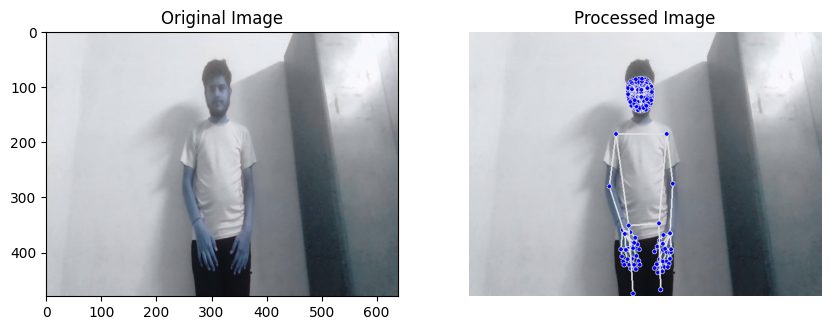

In [ ]:
# img = cv2.imread(os.path.join(word_data_path, 'ANGRY/ANGRY (2).jpg'))
img = cv2.imread('/content/drive/MyDrive/Sign-Language-Translator/data_include/WIN_20251028_21_19_19_Pro.jpg')
plt.figure(figsize=(10, 10))

processed_img = process_frame(img)
axs = plt.subplot(121)
axs.set_title('Original Image')
plt.imshow(cv2.resize(img, (640,480)))

axs = plt.subplot(122)
axs.set_title('Processed Image')
plt.imshow(processed_img)

plt.axis('off')

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = process_frame(frame)

    cv2.imshow('Hand Landmarks', frame)
    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
cv2.destroyAllWindows()

Data Preprocessing and Loading

In [ ]:
default_landmarks = torch.load('/content/drive/MyDrive/Sign-Language-Translator/data_include/default_landmarks.pth')

In [ ]:
def normalize_rotation(landmarks):
    """
    Rotate landmarks to a canonical orientation (front-facing, upright).
    landmarks: list of tensors of shape (N, 3)
    """
    # Extract key landmarks
    left_shoulder = landmarks[2][11]
    right_shoulder = landmarks[2][12]
    left_hip = landmarks[2][23]
    right_hip = landmarks[2][24]

    # Compute midpoints
    shoulder_center = (left_shoulder + right_shoulder) / 2.0
    hip_center = (left_hip + right_hip) / 2.0

    # Define axes vectors
    x_axis = right_shoulder - left_shoulder
    y_axis = shoulder_center - hip_center
    z_axis = torch.cross(x_axis, y_axis, dim=0)

    # Normalization vectors
    x_axis = x_axis / (torch.norm(x_axis) + 1e-6)
    y_axis = y_axis / (torch.norm(y_axis) + 1e-6)
    z_axis = z_axis / (torch.norm(z_axis) + 1e-6)

    # Rotation matrix mapping body → world canonical
    R = torch.stack([x_axis, y_axis, z_axis], dim=1)
    R_inv = R.T  # rotate body to canonical frame

    # Center and rotate
    landmarks_centered = [lm - shoulder_center for lm in landmarks]
    landmarks_rot = [torch.matmul(R_inv, lm.T).T for lm in landmarks_centered]

    return landmarks_rot

In [ ]:
def normalize_vector(v):
    return v / (torch.norm(v) + 1e-8)

def hand_rotation_matrix(wrist, index, pinky):
    """
    Compute 3D rotation matrix for a hand using wrist-index-pinky landmarks.
    """
    x_axis = normalize_vector(index - wrist)
    y_axis = normalize_vector(pinky - wrist)
    z_axis = normalize_vector(torch.cross(x_axis, y_axis))

    # Re-orthogonalize
    y_axis = normalize_vector(torch.cross(z_axis, x_axis))
    R = torch.stack([x_axis, y_axis, z_axis], dim=1)  # shape (3,3)
    return R

def align_hand_landmarks(last_hand, curr_pose, part_type):
    """
    Align previous hand landmarks to current hand rotation using 3D rotation matrix.
    """
    if curr_pose is None:
        return last_hand

    # Extract landmarks
    wrist_prev, index_prev, pinky_prev = last_hand[0], last_hand[5], last_hand[17]

    if part_type == 'left_hand':
      wrist_curr, index_curr, pinky_curr = curr_pose[16], curr_pose[20], curr_pose[18]
    else:
      wrist_curr, index_curr, pinky_curr = curr_pose[15], curr_pose[19], curr_pose[17]

    # Get rotation matrices for previous and current hand orientations
    R_prev = hand_rotation_matrix(wrist_prev, index_prev, pinky_prev)
    R_curr = hand_rotation_matrix(wrist_curr, index_curr, pinky_curr)

    # Compute rotation from prev → curr
    R = R_curr @ R_prev.T  # shape (3,3)

    # Center last hand to its wrist
    L_centered = last_hand - wrist_prev

    # Rotate and translate
    L_rotated = (L_centered @ R.T) + wrist_curr

    return L_rotated

In [ ]:
def normalize_landmarks(landmarks):
  landmarks = normalize_rotation(landmarks)

  left_shoulder, right_shoulder = landmarks[2][11], landmarks[2][12]
  left_hip, right_hip = landmarks[2][23], landmarks[2][24]

  # # shoulder center
  root = (left_shoulder + right_shoulder) / 2.0

  scale = torch.linalg.norm(left_shoulder - right_shoulder).to(dtype=torch.float64)

  # # avoid division by 0
  if scale < 1e-6:
    scale = 1.0

  landmarks[0] = (landmarks[0] - root) / scale
  landmarks[1] = (landmarks[1] - root) / scale
  landmarks[2] = (landmarks[2] - root) / scale
  # landmarks[3] = (landmarks[3] - root) / scale

  # new_lm = old_lm + (to_point - from_point)
  landmarks[0] += (landmarks[2][15] - landmarks[0][0])
  landmarks[1] += (landmarks[2][16] - landmarks[1][0])
  # landmarks[3] += (landmarks[2][0] - landmarks[3][1])

  return landmarks

In [ ]:
def extract_landmarks(image):
  if image.shape[0] == 3:
    image = image.permute(1, 2, 0)

  image = np.array(image)

  num_landmarks = {
      'left_hand': 21,
      'right_hand': 21,
      'pose': 25,
      # 'pose': 33,
      # 'face': 468
  }

  result = detect_landmarks(image)

  extracted_result = {}

  for part_type, landmarks in result.items():
    if landmarks:
      landmark_list = torch.tensor([(lm.x,lm.y,lm.z) for lm in landmarks.landmark], dtype=torch.float64)
      extracted_result[part_type] = landmark_list[:num_landmarks[part_type]]

  return extracted_result

In [ ]:
def correct_landmarks(extracted_landmarks, prev_landmarks):
  original_landmarks = []
  parts = ['left_hand', 'right_hand', 'pose']

  if 'pose' in extracted_landmarks:
    pose_lm = extracted_landmarks['pose']
  else:
    pose_lm = prev_landmarks['pose']

  for part_type in parts:
    if part_type not in extracted_landmarks:
      if part_type == 'left_hand' or part_type == 'right_hand':
        # Missing Hand Landmarks
        landmark_list = align_hand_landmarks(prev_landmarks[part_type], pose_lm, part_type)
        # landmark_list = torch.tensor([(0,0,0)] * num_landmarks[part_type], dtype=torch.float64)

      else:
        # Missing Pose Landmarks
        landmark_list = prev_landmarks[part_type]

    else:
        # Available landmarks
        landmark_list = extracted_landmarks[part_type]

    original_landmarks.append(landmark_list)

  original_landmarks = normalize_landmarks(original_landmarks)

  original_landmarks = torch.concat(original_landmarks, dim=0)
  return original_landmarks.to(dtype=torch.float64)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Sign-Language-Translator/data_include/WIN_20251028_21_19_19_Pro.jpg')
img = cv2.resize(img, (640,480))

default_landmarks = extract_landmarks(img)
print(default_landmarks['left_hand'].shape, default_landmarks['right_hand'].shape, default_landmarks['pose'].shape)

torch.save(default_landmarks, 'default_landmarks.pth')

torch.Size([21, 3]) torch.Size([21, 3]) torch.Size([25, 3])


In [ ]:
img = cv2.imread(os.path.join(word_data_path, 'COLLEGE_SCHOOL/FROM (1).jpg'))
landmarks = extract_landmarks(img)
landmarks = correct_landmarks(landmarks, default_landmarks)
landmarks.shape

torch.Size([67, 3])

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.PILToTensor(),
    v2.RandomHorizontalFlip(p=0.5),

    # ✅ Spatial variations
    v2.RandomResizedCrop(size=(256,256), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    # v2.RandomPerspective(distortion_scale=0.1, p=0.5),
    v2.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),

    # ✅ Photometric variations
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    v2.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),

    # ✅ Occlusion & robustness
    v2.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

Data Visualization

In [ ]:
skeleton_edges = [
    # Left Hand
    (0, 1), (1, 2), (2, 3), (3, 4), # thumb
    (0, 5), (5, 6), (6, 7), (7, 8), # index
    (0, 9), (9, 10), (10, 11), (11, 12), # middle
    (0, 13), (13, 14), (14, 15), (15, 16), # ring
    (0, 17), (17, 18), (18, 19), (19, 20), # pinky

    # Right Hand
    (21, 22), (22, 23), (23, 24), (24, 25), # thumb
    (21, 26), (26, 27), (27, 28), (28, 29), # index
    (21, 30), (30, 31), (31, 32), (32, 33), # middle
    (21, 34), (34, 35), (35, 36), (36, 37), # ring
    (21, 38), (38, 39), (39, 40), (40, 41), # pinky

    # Pose
    (53, 55), (55, 57), # Left Arm
    (54, 56), (56, 58), # Right Arm
    (53, 54),             # Shoulders
    (53, 65), (54, 66),   # Torso
    (65, 66),             # Hips
    (42, 53), (42, 54),   # Nose to Shoulders
    # (66, 68), (68, 70),   # Hips to Left Leg
    # (65, 67), (67, 69),   # Hips to Right Leg

    # (0, 57), (21, 58) # Hands wrist to Pose wrist
]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_frame_landmarks(frame_data_list, skeleton_edges):
  """
  Visualizes the landmarks for a list of frames in 3D subplots.

  Args:
    frame_data_list (list): A list of torch.Tensor, where each tensor is of shape
                            [num_landmarks, 3] containing the x, y, z coordinates
                            of landmarks for a single frame.
    skeleton_edges (list): A list of tuples representing connections between landmarks.
  """
  num_frames = len(frame_data_list)
  cols = 5 # Number of columns in the subplot grid
  rows = (num_frames + cols - 1) // cols # Calculate number of rows

  fig = plt.figure(figsize=(cols * 3, rows * 3))

  for i, (lms, _) in enumerate(frame_data_list):
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

    # Plot the landmarks
    ax.scatter(lms[:21, 0], lms[:21, 1], lms[:21, 2], marker='o')
    ax.scatter(lms[21:42, 0], lms[21:42, 1], lms[21:42, 2], marker='_')
    ax.scatter(lms[42, 0], lms[42, 1], lms[42, 2], marker='*')
    ax.scatter(lms[43:75, 0], lms[43:75, 1], lms[43:75, 2], marker='.')
    ax.scatter(lms[75:, 0], lms[75:, 1], lms[75:, 2], marker='x')

    # Plot the connections (skeleton)
    for k, l in skeleton_edges:
      x = [lms[k, 0], lms[l, 0]]
      y = [lms[k, 1], lms[l, 1]]
      z = [lms[k, 2], lms[l, 2]]
      ax.plot(x, y, z, 'blue')

    ax.set_title(f'Frame {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # plt.gca().invert_xaxis()
    # plt.gca().invert_yaxis()
    plt.gca().invert_zaxis()

  plt.tight_layout()
  plt.show()

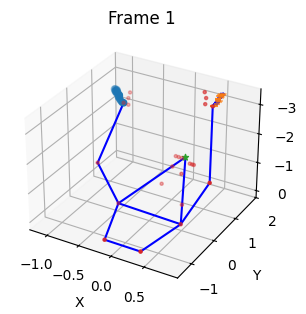

In [ ]:
# Mediapipe Extracted Landmarks Visualization
# lst = [train_dataset[i] for i in range(200,250)]
lst = [(landmarks, 'me')]
visualize_frame_landmarks(lst, skeleton_edges)

In [ ]:
# def visualize_frames(frame_data_list):
#   """
#   Visualizes list of frames in subplots.
#   """

#   num_frames = len(frame_data_list)
#   cols = 5 # Number of columns in the subplot grid
#   rows = (num_frames + cols - 1) // cols # Calculate number of rows

#   fig = plt.figure(figsize=(cols*3, rows*3))

#   for i, (img, _, _) in enumerate(frame_data_list):
#     ax = fig.add_subplot(rows, cols, i + 1)
#     ax.imshow(img.permute(1, 2, 0) / 255.0)

#     ax.set_title(f'Frame {i+1}')

#   plt.tight_layout()
#   plt.show()

In [ ]:
# visualize_frames(lst)

In [ ]:
# right hand wrist
# lm = train_dataset[21][1]
lm = landmarks
lm[0], lm[21], lm[65], lm[66]

(tensor([[-0.8510,  1.2173, -2.4872],
         [-0.8935,  1.2643, -2.4505],
         [-0.9421,  1.3264, -2.4489],
         [-0.9828,  1.3793, -2.4602],
         [-1.0144,  1.4229, -2.4660],
         [-0.9847,  1.3898, -2.5124],
         [-1.0520,  1.4665, -2.5281],
         [-1.0882,  1.5086, -2.5334],
         [-1.1140,  1.5417, -2.5368],
         [-0.9871,  1.3914, -2.5451],
         [-1.0629,  1.4732, -2.5683],
         [-1.1033,  1.5233, -2.5779],
         [-1.1325,  1.5649, -2.5854],
         [-0.9856,  1.3862, -2.5680],
         [-1.0530,  1.4633, -2.5927],
         [-1.0876,  1.5124, -2.6050],
         [-1.1132,  1.5540, -2.6138],
         [-0.9792,  1.3725, -2.5811],
         [-1.0276,  1.4354, -2.6081],
         [-1.0534,  1.4779, -2.6231],
         [-1.0710,  1.5110, -2.6322]], dtype=torch.float64),
 tensor([[ 0.4913,  1.3414, -3.0688],
         [ 0.4979,  1.4145, -3.0399],
         [ 0.5019,  1.4989, -3.0459],
         [ 0.5047,  1.5723, -3.0673],
         [ 0.5044,  1.6277,